# Shap visualisation

In [1]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
app_train = pd.read_csv("data/application_train.csv")
app_test = pd.read_csv("data/application_test.csv")

In [3]:
def preprocessing(app_train, app_test):

    targets = app_train

    # Replace Own car by binary term
    app_train['FLAG_OWN_CAR'].replace(to_replace=['N'], value=0, inplace=True)
    app_train['FLAG_OWN_CAR'].replace(to_replace=['Y'], value=1, inplace=True)

    app_test['FLAG_OWN_CAR'].replace(to_replace=['N'], value=0, inplace=True)
    app_test['FLAG_OWN_CAR'].replace(to_replace=['Y'], value=1, inplace=True)

    # Replace Own realty by binary term
    app_train['FLAG_OWN_REALTY'].replace(to_replace=['N'], value=0, inplace=True)
    app_train['FLAG_OWN_REALTY'].replace(to_replace=['Y'], value=1, inplace=True)

    app_test['FLAG_OWN_REALTY'].replace(to_replace=['N'], value=0, inplace=True)
    app_test['FLAG_OWN_REALTY'].replace(to_replace=['Y'], value=1, inplace=True)

    # Replace NAME_CONTRACT_TYPE by binary values
    app_train['NAME_CONTRACT_TYPE'].replace(to_replace=['Cash loans'], value=1, inplace=True)
    app_train['NAME_CONTRACT_TYPE'].replace(to_replace=['Revolving loans'], value=2, inplace=True)

    app_test['NAME_CONTRACT_TYPE'].replace(to_replace=['Cash loans'], value=1, inplace=True)
    app_test['NAME_CONTRACT_TYPE'].replace(to_replace=['Revolving loans'], value=2, inplace=True)

    app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

    app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})

    app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

    app_test['DAYS_EMPLOYED'] = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})

    app_train = pd.get_dummies(app_train, drop_first=True)
    app_test = pd.get_dummies(app_test, drop_first=True)

    tmp_0 = app_train[targets['TARGET'] == 0]
    tmp_1 = app_train[targets['TARGET'] == 1]

    tmp_0 = shuffle(tmp_0)
    tmp_0 = tmp_0.head(tmp_1.shape[0])

    frames = [tmp_0, tmp_1]
    app_train_balanced = pd.concat(frames)

    most_corr_features = ["DEF_60_CNT_SOCIAL_CIRCLE",
                          "DEF_30_CNT_SOCIAL_CIRCLE",
                          "LIVE_CITY_NOT_WORK_CITY",
                          "OWN_CAR_AGE",
                          "DAYS_REGISTRATION",
                          "OCCUPATION_TYPE_Laborers",
                          "FLAG_DOCUMENT_3",
                          "REG_CITY_NOT_LIVE_CITY",
                          "FLAG_EMP_PHONE",
                          "REG_CITY_NOT_WORK_CITY",
                          "DAYS_ID_PUBLISH",
                          "CODE_GENDER_M",
                          "DAYS_LAST_PHONE_CHANGE",
                          "NAME_INCOME_TYPE_Working",
                          "REGION_RATING_CLIENT",
                          "REGION_RATING_CLIENT_W_CITY",
                          "DAYS_EMPLOYED",
                          "DAYS_BIRTH",
                          "EXT_SOURCE_3",
                          "EXT_SOURCE_2",
                          "EXT_SOURCE_1",
                          "NAME_INCOME_TYPE_Pensioner",
                          "DAYS_EMPLOYED_ANOM",
                          "ORGANIZATION_TYPE_XNA",
                          "FLOORSMAX_AVG",
                          "FLOORSMAX_MEDI",
                          "FLOORSMAX_MODE",
                          "AMT_GOODS_PRICE",
                          "REGION_POPULATION_RELATIVE",
                          "ELEVATORS_AVG",
                          "ELEVATORS_MEDI",
                          "FLOORSMIN_AVG",
                          "FLOORSMIN_MEDI",
                          "WALLSMATERIAL_MODE_Panel",
                          "LIVINGAREA_AVG",
                          "LIVINGAREA_MEDI",
                          "FLOORSMIN_MODE"
                          ]

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    app_train[most_corr_features] = imputer.fit_transform(app_train[most_corr_features])
    app_train_balanced[most_corr_features] = imputer.fit_transform(app_train_balanced[most_corr_features])

    app_train = app_train[most_corr_features]
    app_test = app_test[most_corr_features]
    app_train_balanced = app_train_balanced[most_corr_features]

    scaler = MinMaxScaler(feature_range=(0, 1))
    imputer.fit(app_train)
    app_train = imputer.transform(app_train)
    app_test = imputer.transform(app_test)
    app_train_balanced = imputer.transform(app_train_balanced)

    app_train = scaler.fit_transform(app_train)
    app_test = scaler.fit_transform(app_test)
    app_train_balanced = scaler.fit_transform(app_train_balanced)

    return app_train, app_test, app_train_balanced


In [4]:
print("Preprocessing Data")

labels = app_train["TARGET"]
most_corr_features = ["DEF_60_CNT_SOCIAL_CIRCLE",
                          "DEF_30_CNT_SOCIAL_CIRCLE",
                          "LIVE_CITY_NOT_WORK_CITY",
                          "OWN_CAR_AGE",
                          "DAYS_REGISTRATION",
                          "OCCUPATION_TYPE_Laborers",
                          "FLAG_DOCUMENT_3",
                          "REG_CITY_NOT_LIVE_CITY",
                          "FLAG_EMP_PHONE",
                          "REG_CITY_NOT_WORK_CITY",
                          "DAYS_ID_PUBLISH",
                          "CODE_GENDER_M",
                          "DAYS_LAST_PHONE_CHANGE",
                          "NAME_INCOME_TYPE_Working",
                          "REGION_RATING_CLIENT",
                          "REGION_RATING_CLIENT_W_CITY",
                          "DAYS_EMPLOYED",
                          "DAYS_BIRTH",
                          "EXT_SOURCE_3",
                          "EXT_SOURCE_2",
                          "EXT_SOURCE_1",
                          "NAME_INCOME_TYPE_Pensioner",
                          "DAYS_EMPLOYED_ANOM",
                          "ORGANIZATION_TYPE_XNA",
                          "FLOORSMAX_AVG",
                          "FLOORSMAX_MEDI",
                          "FLOORSMAX_MODE",
                          "AMT_GOODS_PRICE",
                          "REGION_POPULATION_RELATIVE",
                          "ELEVATORS_AVG",
                          "ELEVATORS_MEDI",
                          "FLOORSMIN_AVG",
                          "FLOORSMIN_MEDI",
                          "WALLSMATERIAL_MODE_Panel",
                          "LIVINGAREA_AVG",
                          "LIVINGAREA_MEDI",
                          "FLOORSMIN_MODE"
                          ]

app_train, app_test, app_train_balanced = preprocessing(app_train, app_test)

Preprocessing Data


In [5]:
print("XGBoost : Splitting data")
X_train, X_test, y_train, y_test = train_test_split(app_train, labels, test_size=0.33, random_state=42)

XGBoost : Splitting data


In [6]:
print("XGBoost : Fitting data")
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

print("XGBoost : Predict data")
predictions = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
f1_score_xgb = f1_score(y_test, predictions)
print("______________")
print("Xgboost")
print("The accuracy of the model is {} %".format(accuracy*100))
print("The RMSE of the model is {}".format(rmse))
print("The F1 Score of the model is {}".format(f1_score_xgb))

XGBoost : Fitting data
XGBoost : Predict data
______________
Xgboost
The accuracy of the model is 91.9618837394929 %
The RMSE of the model is 0.2835157184444471
The F1 Score of the model is 0.051401325735550646


## Shap initialisation

In [7]:
shap.initjs()
explainer = shap.TreeExplainer(model_xgb)

shap_values = explainer.shap_values(app_train)

In [9]:
shap.force_plot(explainer.expected_value, shap_values[2], app_train[2], feature_names=most_corr_features)

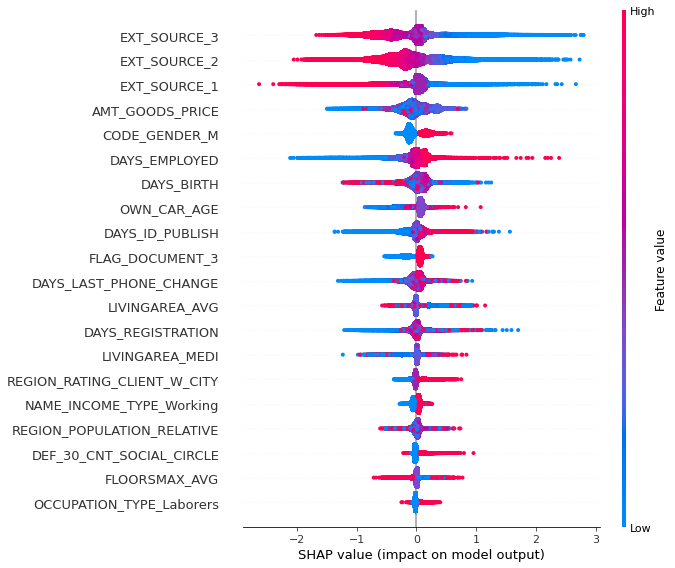

In [10]:
shap.summary_plot(shap_values, app_train, feature_names=most_corr_features)